## Install required libraries

In [17]:
# !pip install dash dash-core-components dash-html-components dash-bootstrap-components plotly

## Step 1: Extract and Load the Data


In [18]:
import pandas as pd
# Load the dataset
data_path = 'twitter_combined.txt'  # Replace with your actual extracted file path
df = pd.read_csv(data_path, sep=' ', names=['Source', 'Target'])

## Step 2: Create a NetworkX Graph
creates a NetworkX graph from the pandas DataFrame, using 'Source' and 'Target' columns as edges.

In [19]:
import networkx as nx
sampled_df = df.sample(n=5000)
# Create the graph
G = nx.from_pandas_edgelist(sampled_df, 'Source', 'Target')

# Basic properties
print(f'Number of nodes: {G.number_of_nodes()}')
print(f'Number of edges: {G.number_of_edges()}')

Number of nodes: 7244
Number of edges: 4993


## Step 3: Calculate Centrality Measures
  df['degree'] = df['Source'].map(dict(G.degree)) maps the degree of each node to the DataFrame.
  
  df['clustering'] = df['Source'].map(nx.clustering(G)) maps the clustering coefficient.
  
  df['betweenness'] = df['Source'].map(nx.betweenness_centrality(G)) maps the betweenness centrality.
  
  df['closeness'] = df['Source'].map(nx.closeness_centrality(G)) maps the closeness centrality.
  
  df['eigenvector'] = df['Source'].map(nx.eigenvector_centrality(G)) maps the eigenvector centrality.

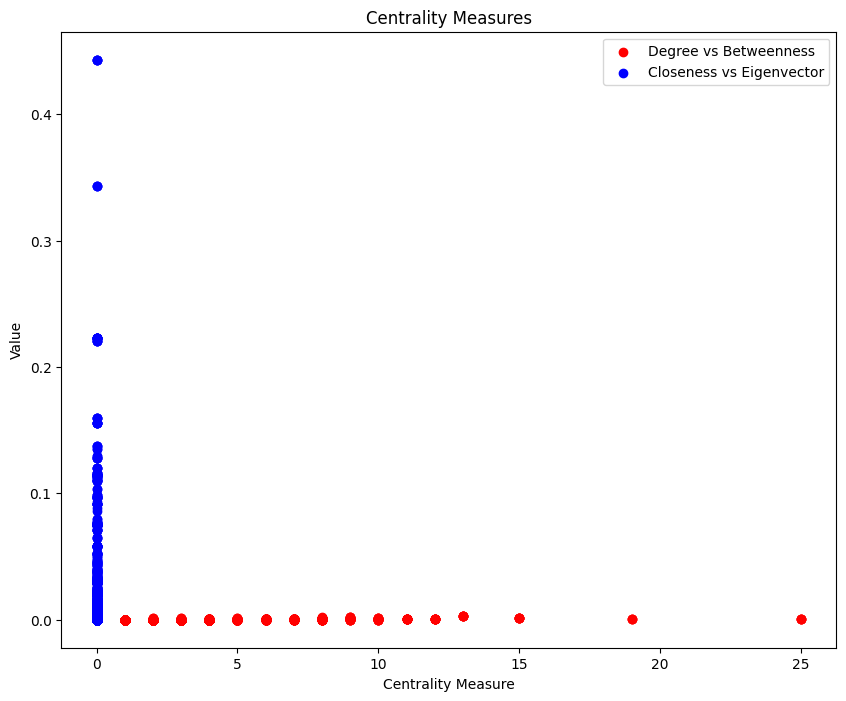

In [20]:
import matplotlib.pyplot as plt

# Calculate centrality measures for the sampled data
sampled_df['degree'] = sampled_df['Source'].map(dict(G.degree))
sampled_df['clustering'] = sampled_df['Source'].map(nx.clustering(G))
sampled_df['betweenness'] = sampled_df['Source'].map(nx.betweenness_centrality(G))
sampled_df['closeness'] = sampled_df['Source'].map(nx.closeness_centrality(G))
sampled_df['eigenvector'] = sampled_df['Source'].map(nx.eigenvector_centrality(G, max_iter=500, tol=1e-06))

# Plot centrality measures
plt.figure(figsize=(10, 8))
plt.scatter(sampled_df['degree'], sampled_df['betweenness'], c='r', label='Degree vs Betweenness')
plt.scatter(sampled_df['closeness'], sampled_df['eigenvector'], c='b', label='Closeness vs Eigenvector')
plt.xlabel('Centrality Measure')
plt.ylabel('Value')
plt.legend()
plt.title('Centrality Measures')
plt.show()


## Step 4: Community Detection
communities = greedy_modularity_communities(G) detects communities in the graph.

community_map is a dictionary that maps each node to its community.

The for loop iterates through the communities and assigns a community ID to each node.

df['community'] = df['Source'].map(community_map) maps the community IDs to the DataFrame.

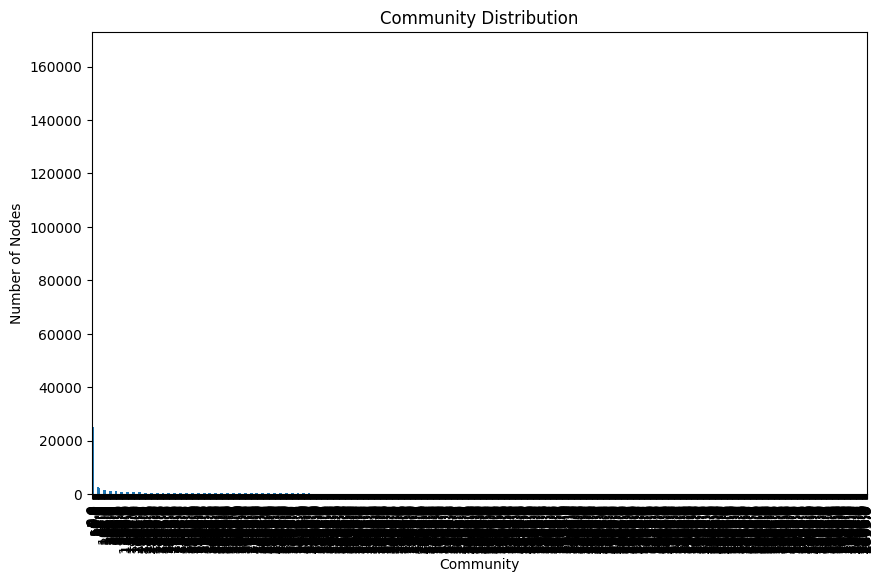

In [21]:
from networkx.algorithms.community import greedy_modularity_communities
import numpy as np

# Community detection
communities = greedy_modularity_communities(G)
community_map = {}
for i, community in enumerate(communities):
    for node in community:
        community_map[node] = i
df['community'] = df['Source'].map(community_map)

# Plot community distribution
community_counts = df['community'].value_counts()
plt.figure(figsize=(10, 6))
community_counts.plot(kind='bar')
plt.xlabel('Community')
plt.ylabel('Number of Nodes')
plt.title('Community Distribution')
plt.show()

## Step 5: Anomaly Detection
### Prepare data for anomaly detection:
    features = df[['degree', 'clustering', 'betweenness', 'closeness', 'eigenvector']] selects the features for anomaly detection.
    scaler = StandardScaler() creates a StandardScaler object.
    scaled_features = scaler.fit_transform(features) scales the features.
### Isolation Forest:
    if_model = IsolationForest(contamination=0.01) creates an Isolation Forest model with a contamination rate of 1%.
    df['if_anomaly'] = if_model.fit_predict(scaled_features) fits the model and predicts anomalies.
    df['if_anomaly'] = df['if_anomaly'].map({1: 0, -1: 1}) maps the predictions to 0 (normal) and 1 (anomaly).
### One-Class SVM:
    ocsvm_model = OneClassSVM() creates a One-Class SVM model.
    df['svm_anomaly'] = ocsvm_model.fit_predict(scaled_features) fits the model and predicts anomalies.
    df['svm_anomaly'] = df['svm_anomaly'].map({1: 0, -1: 1}) maps the predictions to 0 (normal) and 1 (anomaly).
### Combine results:
    df['combined_anomaly'] = df[['if_anomaly', 'svm_anomaly']].max(axis=1) combines the results of both models, marking a node as an anomaly if either model detects it as an anomaly.


Isolation Forest - Accuracy: 0.94, Precision: 0.02
One-Class SVM - Accuracy: 0.31, Precision: 0.05


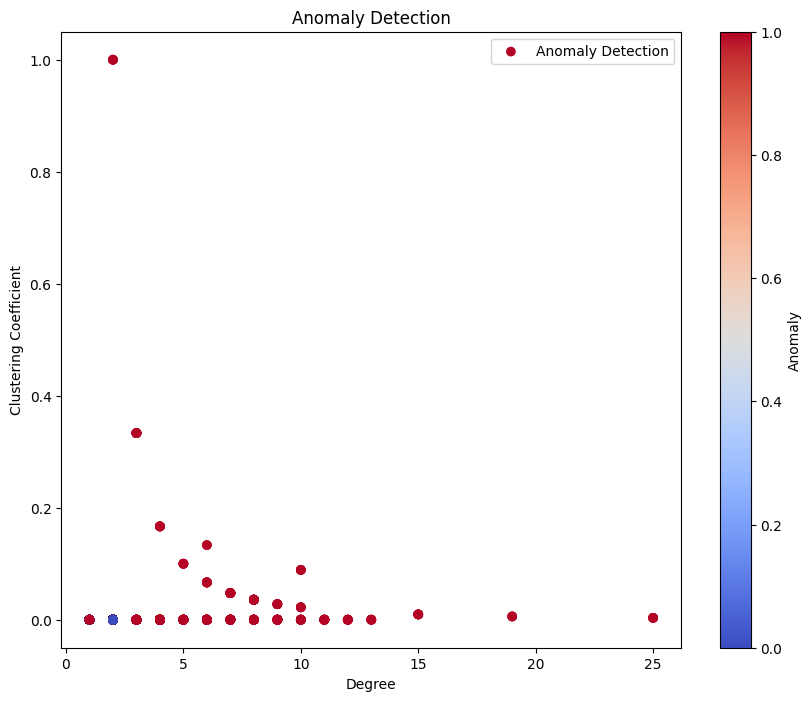

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.metrics import accuracy_score, precision_score


# Create synthetic ground truth labels
np.random.seed(42)  # For reproducibility
sampled_df['label'] = np.random.choice([0, 1], size=len(sampled_df), p=[0.95, 0.05])

# Prepare data for anomaly detection
features = sampled_df[['degree', 'clustering', 'betweenness', 'closeness', 'eigenvector']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Isolation Forest
if_model = IsolationForest(contamination=0.01)
sampled_df['if_anomaly'] = if_model.fit_predict(scaled_features)
sampled_df['if_anomaly'] = sampled_df['if_anomaly'].map({1: 0, -1: 1})

# One-Class SVM
ocsvm_model = OneClassSVM()
sampled_df['svm_anomaly'] = ocsvm_model.fit_predict(scaled_features)
sampled_df['svm_anomaly'] = sampled_df['svm_anomaly'].map({1: 0, -1: 1})

# Combine results
sampled_df['combined_anomaly'] = sampled_df[['if_anomaly', 'svm_anomaly']].max(axis=1)

# Assuming ground truth labels are available in 'label' column
# Calculate accuracy and precision for Isolation Forest
if_accuracy = accuracy_score(sampled_df['label'], sampled_df['if_anomaly'])
if_precision = precision_score(sampled_df['label'], sampled_df['if_anomaly'])

# Calculate accuracy and precision for One-Class SVM
svm_accuracy = accuracy_score(sampled_df['label'], sampled_df['svm_anomaly'])
svm_precision = precision_score(sampled_df['label'], sampled_df['svm_anomaly'])

print(f'Isolation Forest - Accuracy: {if_accuracy:.2f}, Precision: {if_precision:.2f}')
print(f'One-Class SVM - Accuracy: {svm_accuracy:.2f}, Precision: {svm_precision:.2f}')

# Plot anomalies
plt.figure(figsize=(10, 8))
plt.scatter(sampled_df['degree'], sampled_df['clustering'], c=sampled_df['combined_anomaly'], cmap='coolwarm', label='Anomaly Detection')
plt.xlabel('Degree')
plt.ylabel('Clustering Coefficient')
plt.title('Anomaly Detection')
plt.colorbar(label='Anomaly')
plt.legend()
plt.show()


## Step 6: Privacy Risk Scoring
### Define Privacy Risk Function:
    def calculate_privacy_risk(row): defines a function to calculate the privacy risk score.
    The function aggregates various centrality measures with specified weights to compute the risk score.
### Calculate Privacy Risk:
    df['privacy_risk'] = df.apply(calculate_privacy_risk, axis=1) applies the function to each row in the DataFrame to calculate the privacy risk score.

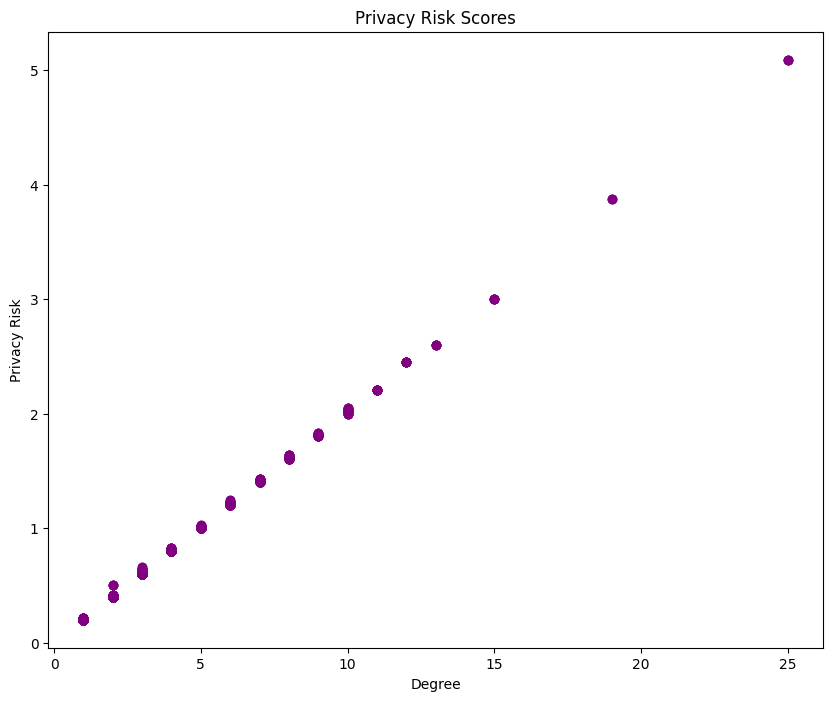

In [23]:
def calculate_privacy_risk(row):
    # Example scoring system, adjust weights as needed
    risk_score = (row['degree'] * 0.2 +
                  row['clustering'] * 0.1 +
                  row['betweenness'] * 0.3 +
                  row['closeness'] * 0.2 +
                  row['eigenvector'] * 0.2)
    return risk_score

sampled_df['privacy_risk'] = sampled_df.apply(calculate_privacy_risk, axis=1)

# Plot privacy risk scores
plt.figure(figsize=(10, 8))
plt.scatter(sampled_df['degree'], sampled_df['privacy_risk'], c='purple', label='Privacy Risk')
plt.xlabel('Degree')
plt.ylabel('Privacy Risk')
plt.title('Privacy Risk Scores')
plt.show()

## Step 7 Differential Privacy

In [24]:
def add_noise(data, epsilon):
    noise = np.random.laplace(0, 1/epsilon, data.shape)
    return data + noise

# Set the privacy budget
epsilon = 0.1

# Add noise to centrality measures
sampled_df['dp_degree'] = add_noise(sampled_df['degree'].values, epsilon)
sampled_df['dp_clustering'] = add_noise(sampled_df['clustering'].values, epsilon)
sampled_df['dp_betweenness'] = add_noise(sampled_df['betweenness'].values, epsilon)
sampled_df['dp_closeness'] = add_noise(sampled_df['closeness'].values, epsilon)
sampled_df['dp_eigenvector'] = add_noise(sampled_df['eigenvector'].values, epsilon)


### Using Differentially Private Data for Anomaly Detection

Isolation Forest with DP - Accuracy: 0.94, Precision: 0.04
One-Class SVM with DP - Accuracy: 0.50, Precision: 0.05


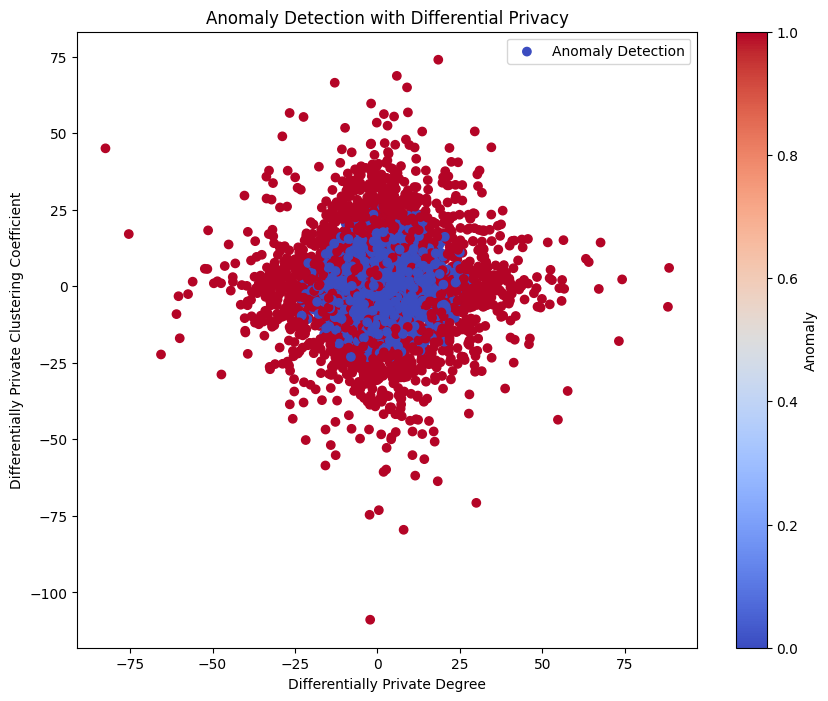

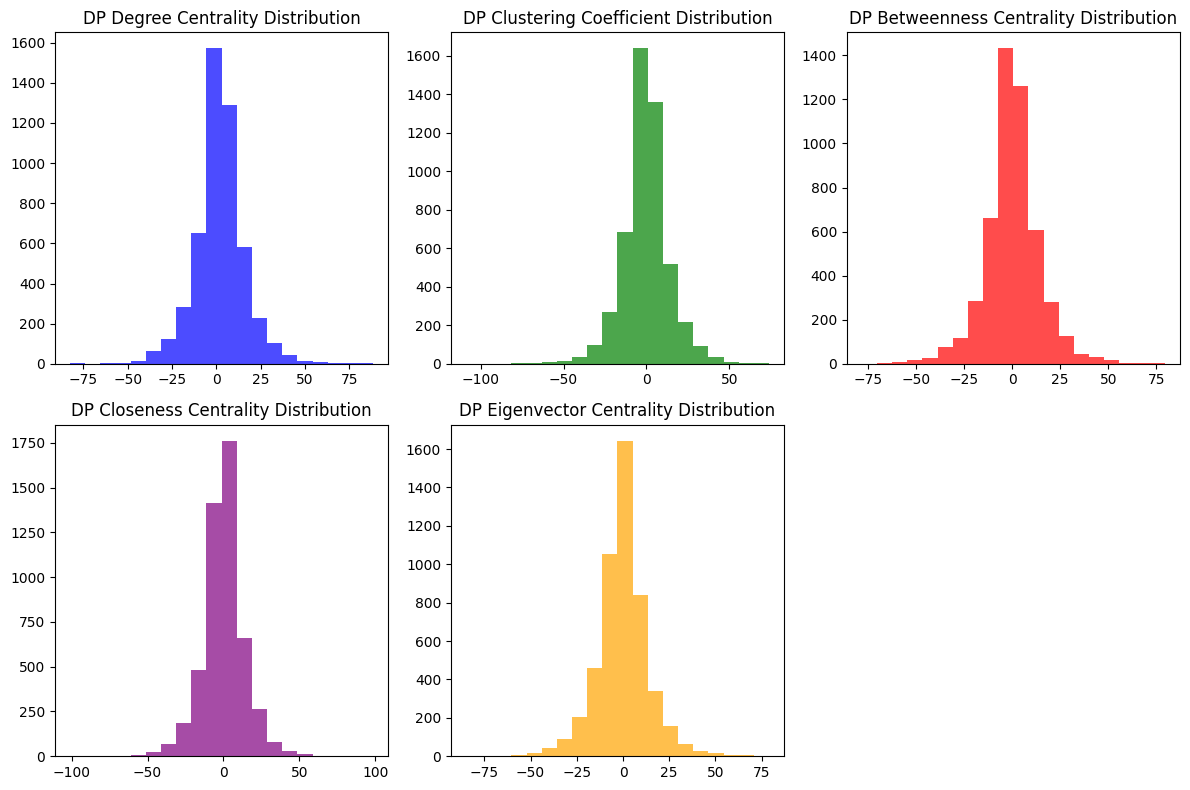

In [25]:
# Prepare data for anomaly detection using differentially private measures
dp_features = sampled_df[['dp_degree', 'dp_clustering', 'dp_betweenness', 'dp_closeness', 'dp_eigenvector']]
scaler = StandardScaler()
scaled_dp_features = scaler.fit_transform(dp_features)

# Isolation Forest with differentially private data
if_model = IsolationForest(contamination=0.01)
sampled_df['if_dp_anomaly'] = if_model.fit_predict(scaled_dp_features)
sampled_df['if_dp_anomaly'] = sampled_df['if_dp_anomaly'].map({1: 0, -1: 1})

# One-Class SVM with differentially private data
ocsvm_model = OneClassSVM()
sampled_df['svm_dp_anomaly'] = ocsvm_model.fit_predict(scaled_dp_features)
sampled_df['svm_dp_anomaly'] = sampled_df['svm_dp_anomaly'].map({1: 0, -1: 1})

# Combine results from differentially private data
sampled_df['combined_dp_anomaly'] = sampled_df[['if_dp_anomaly', 'svm_dp_anomaly']].max(axis=1)

# Calculate accuracy and precision for Isolation Forest with DP data
if_dp_accuracy = accuracy_score(sampled_df['label'], sampled_df['if_dp_anomaly'])
if_dp_precision = precision_score(sampled_df['label'], sampled_df['if_dp_anomaly'])

# Calculate accuracy and precision for One-Class SVM with DP data
svm_dp_accuracy = accuracy_score(sampled_df['label'], sampled_df['svm_dp_anomaly'])
svm_dp_precision = precision_score(sampled_df['label'], sampled_df['svm_dp_anomaly'])

print(f'Isolation Forest with DP - Accuracy: {if_dp_accuracy:.2f}, Precision: {if_dp_precision:.2f}')
print(f'One-Class SVM with DP - Accuracy: {svm_dp_accuracy:.2f}, Precision: {svm_dp_precision:.2f}')

# Plot anomalies
plt.figure(figsize=(10, 8))
plt.scatter(sampled_df['dp_degree'], sampled_df['dp_clustering'], c=sampled_df['combined_dp_anomaly'], cmap='coolwarm', label='Anomaly Detection')
plt.xlabel('Differentially Private Degree')
plt.ylabel('Differentially Private Clustering Coefficient')
plt.title('Anomaly Detection with Differential Privacy')
plt.colorbar(label='Anomaly')
plt.legend()
plt.show()

# Plot distribution of differentially private centrality measures
plt.figure(figsize=(12, 8))
plt.subplot(2, 3, 1)
plt.hist(sampled_df['dp_degree'], bins=20, color='blue', alpha=0.7)
plt.title('DP Degree Centrality Distribution')

plt.subplot(2, 3, 2)
plt.hist(sampled_df['dp_clustering'], bins=20, color='green', alpha=0.7)
plt.title('DP Clustering Coefficient Distribution')

plt.subplot(2, 3, 3)
plt.hist(sampled_df['dp_betweenness'], bins=20, color='red', alpha=0.7)
plt.title('DP Betweenness Centrality Distribution')

plt.subplot(2, 3, 4)
plt.hist(sampled_df['dp_closeness'], bins=20, color='purple', alpha=0.7)
plt.title('DP Closeness Centrality Distribution')

plt.subplot(2, 3, 5)
plt.hist(sampled_df['dp_eigenvector'], bins=20, color='orange', alpha=0.7)
plt.title('DP Eigenvector Centrality Distribution')

plt.tight_layout()
plt.show()

## Using Laplace Mechanism to add some noise and using that data run for anomaly detection using both models and differential privacy

Isolation Forest with DP - Accuracy: 0.94, Precision: 0.08
One-Class SVM with DP - Accuracy: 0.50, Precision: 0.05


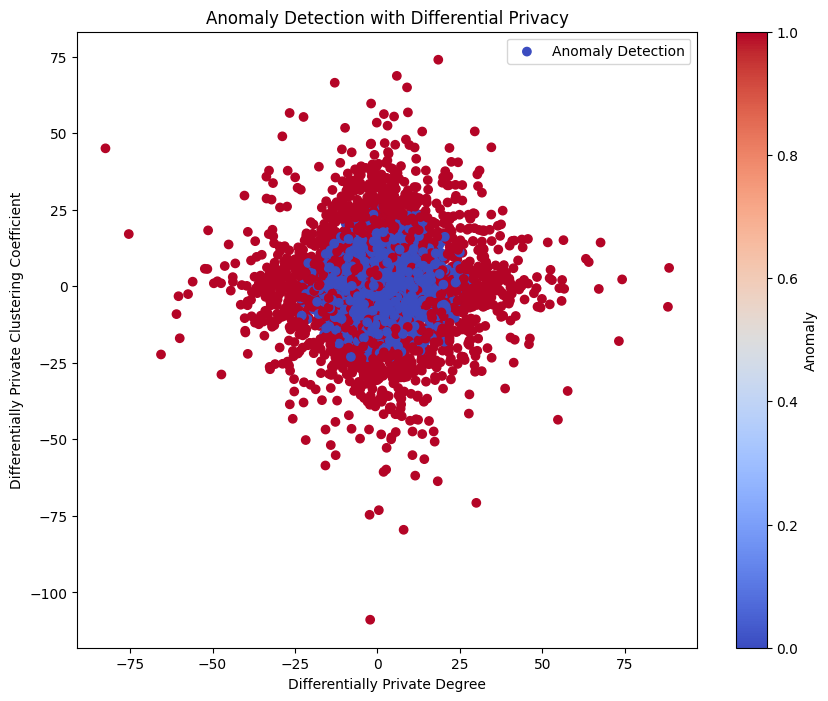

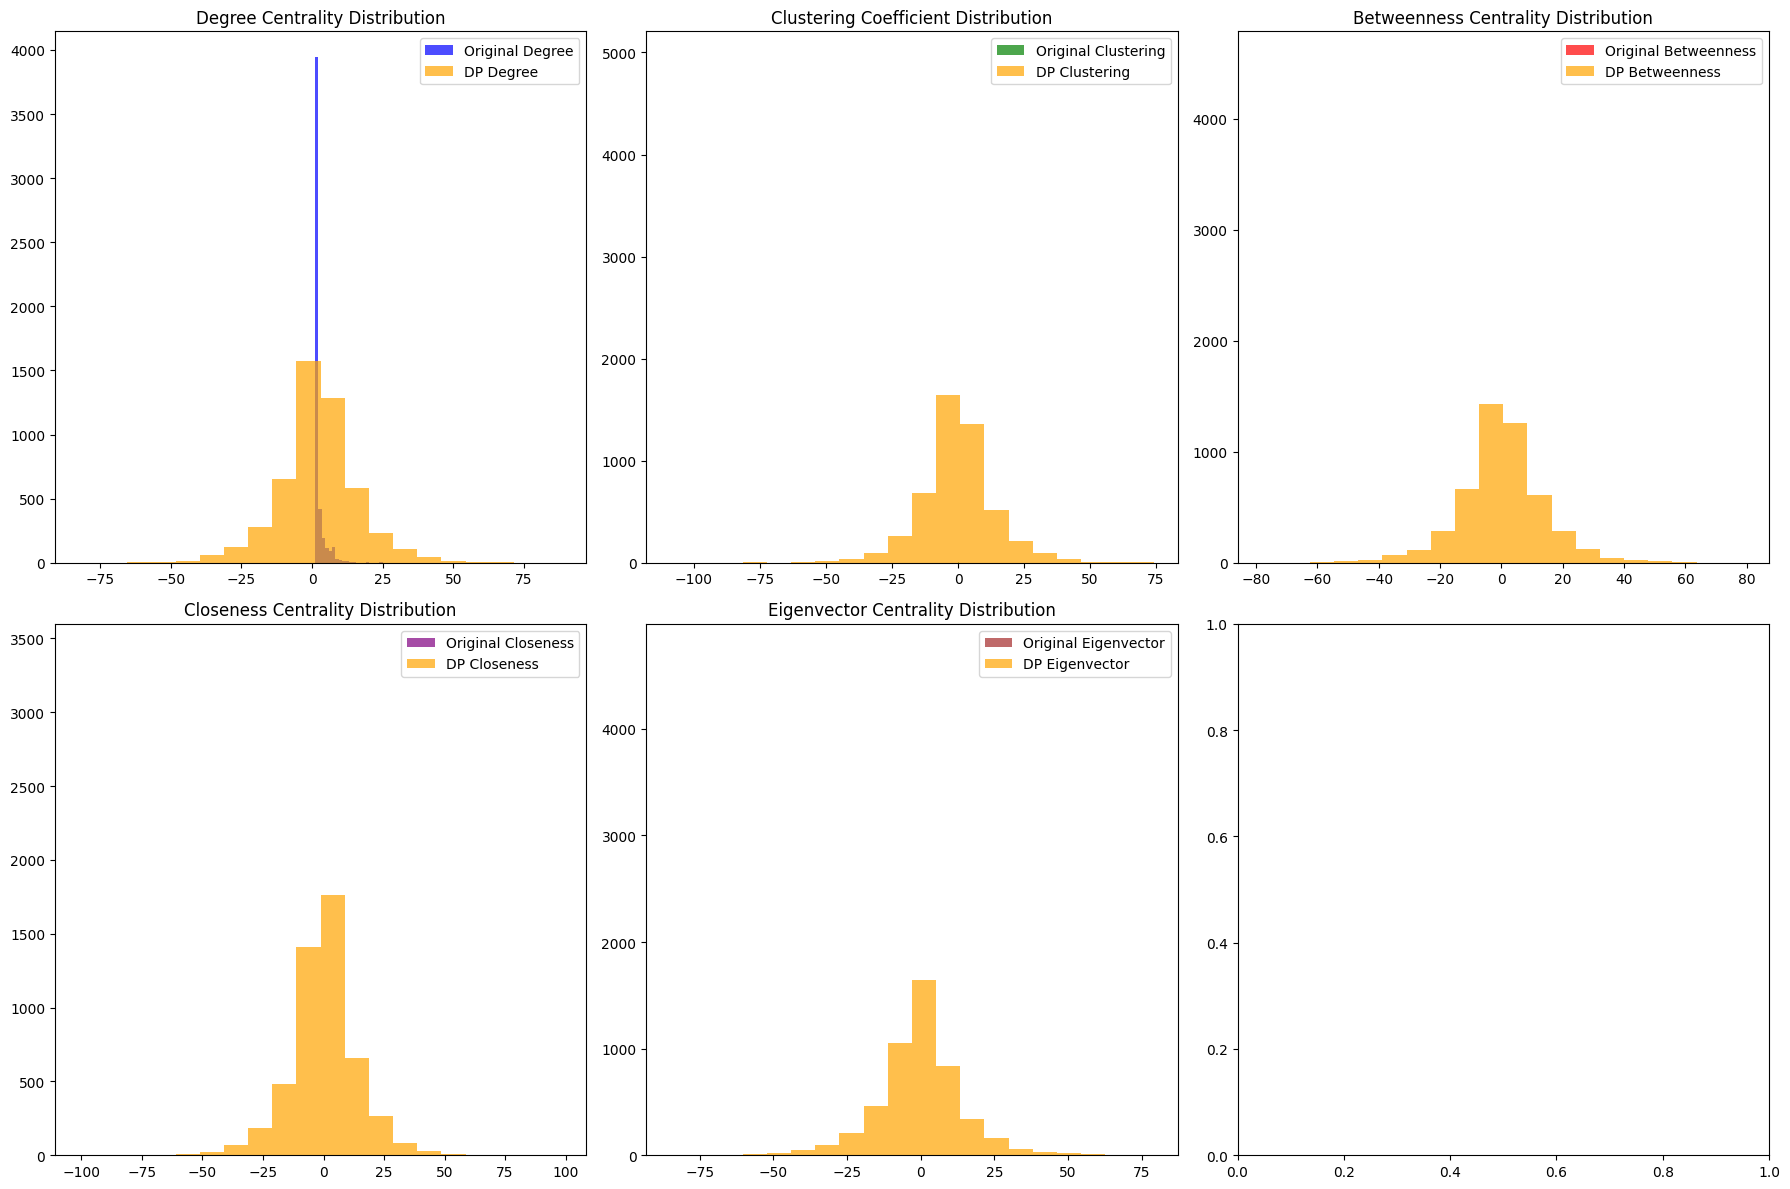

In [27]:


# Create a NetworkX graph from the sampled data
G = nx.from_pandas_edgelist(sampled_df, 'Source', 'Target')

# Calculate centrality measures
sampled_df['degree'] = sampled_df['Source'].map(dict(G.degree))
sampled_df['clustering'] = sampled_df['Source'].map(nx.clustering(G))
sampled_df['betweenness'] = sampled_df['Source'].map(nx.betweenness_centrality(G))
sampled_df['closeness'] = sampled_df['Source'].map(nx.closeness_centrality(G))
sampled_df['eigenvector'] = sampled_df['Source'].map(nx.eigenvector_centrality(G))

# Define the Laplace mechanism function
def add_laplace_noise(data, epsilon, sensitivity=1):
    noise = np.random.laplace(0, sensitivity / epsilon, data.shape)
    return data + noise

# Add noise to centrality measures
epsilon = 0.1  # Privacy budget
sampled_df['dp_degree'] = add_laplace_noise(sampled_df['degree'].values, epsilon)
sampled_df['dp_clustering'] = add_laplace_noise(sampled_df['clustering'].values, epsilon)
sampled_df['dp_betweenness'] = add_laplace_noise(sampled_df['betweenness'].values, epsilon)
sampled_df['dp_closeness'] = add_laplace_noise(sampled_df['closeness'].values, epsilon)
sampled_df['dp_eigenvector'] = add_laplace_noise(sampled_df['eigenvector'].values, epsilon)

# Create synthetic ground truth labels
np.random.seed(42)  # For reproducibility
sampled_df['label'] = np.random.choice([0, 1], size=len(sampled_df), p=[0.95, 0.05])

# Prepare data for anomaly detection using differentially private measures
dp_features = sampled_df[['dp_degree', 'dp_clustering', 'dp_betweenness', 'dp_closeness', 'dp_eigenvector']]
scaler = StandardScaler()
scaled_dp_features = scaler.fit_transform(dp_features)

# Isolation Forest with differentially private data
if_model = IsolationForest(contamination=0.01)
sampled_df['if_dp_anomaly'] = if_model.fit_predict(scaled_dp_features)
sampled_df['if_dp_anomaly'] = sampled_df['if_dp_anomaly'].map({1: 0, -1: 1})

# One-Class SVM with differentially private data
ocsvm_model = OneClassSVM()
sampled_df['svm_dp_anomaly'] = ocsvm_model.fit_predict(scaled_dp_features)
sampled_df['svm_dp_anomaly'] = sampled_df['svm_dp_anomaly'].map({1: 0, -1: 1})

# Combine results from differentially private data
sampled_df['combined_dp_anomaly'] = sampled_df[['if_dp_anomaly', 'svm_dp_anomaly']].max(axis=1)

# Calculate accuracy and precision for Isolation Forest with DP data
if_dp_accuracy = accuracy_score(sampled_df['label'], sampled_df['if_dp_anomaly'])
if_dp_precision = precision_score(sampled_df['label'], sampled_df['if_dp_anomaly'])

# Calculate accuracy and precision for One-Class SVM with DP data
svm_dp_accuracy = accuracy_score(sampled_df['label'], sampled_df['svm_dp_anomaly'])
svm_dp_precision = precision_score(sampled_df['label'], sampled_df['svm_dp_anomaly'])

print(f'Isolation Forest with DP - Accuracy: {if_dp_accuracy:.2f}, Precision: {if_dp_precision:.2f}')
print(f'One-Class SVM with DP - Accuracy: {svm_dp_accuracy:.2f}, Precision: {svm_dp_precision:.2f}')

# Plot anomalies
plt.figure(figsize=(10, 8))
plt.scatter(sampled_df['dp_degree'], sampled_df['dp_clustering'], c=sampled_df['combined_dp_anomaly'], cmap='coolwarm', label='Anomaly Detection')
plt.xlabel('Differentially Private Degree')
plt.ylabel('Differentially Private Clustering Coefficient')
plt.title('Anomaly Detection with Differential Privacy')
plt.colorbar(label='Anomaly')
plt.legend()
plt.show()

# Plot original vs differentially private centrality measures
fig, axs = plt.subplots(2, 3, figsize=(18, 12))

axs[0, 0].hist(sampled_df['degree'], bins=20, color='blue', alpha=0.7, label='Original Degree')
axs[0, 0].hist(sampled_df['dp_degree'], bins=20, color='orange', alpha=0.7, label='DP Degree')
axs[0, 0].set_title('Degree Centrality Distribution')
axs[0, 0].legend()

axs[0, 1].hist(sampled_df['clustering'], bins=20, color='green', alpha=0.7, label='Original Clustering')
axs[0, 1].hist(sampled_df['dp_clustering'], bins=20, color='orange', alpha=0.7, label='DP Clustering')
axs[0, 1].set_title('Clustering Coefficient Distribution')
axs[0, 1].legend()

axs[0, 2].hist(sampled_df['betweenness'], bins=20, color='red', alpha=0.7, label='Original Betweenness')
axs[0, 2].hist(sampled_df['dp_betweenness'], bins=20, color='orange', alpha=0.7, label='DP Betweenness')
axs[0, 2].set_title('Betweenness Centrality Distribution')
axs[0, 2].legend()

axs[1, 0].hist(sampled_df['closeness'], bins=20, color='purple', alpha=0.7, label='Original Closeness')
axs[1, 0].hist(sampled_df['dp_closeness'], bins=20, color='orange', alpha=0.7, label='DP Closeness')
axs[1, 0].set_title('Closeness Centrality Distribution')
axs[1, 0].legend()

axs[1, 1].hist(sampled_df['eigenvector'], bins=20, color='brown', alpha=0.7, label='Original Eigenvector')
axs[1, 1].hist(sampled_df['dp_eigenvector'], bins=20, color='orange', alpha=0.7, label='DP Eigenvector')
axs[1, 1].set_title('Eigenvector Centrality Distribution')
axs[1, 1].legend()

plt.tight_layout()
plt.show()
